In [4]:
from src.preprocessing.dataLoader_CelebA import get_partitioned_dataloaders, create_subset_loader
from src.ml.resNet50 import SiameseResNet
from src.ml.losses_utils import ContrastiveLoss
import torch
from src.ml.hyperparam_study import run_optuna_study

# 1. Load the data

In [5]:
IMAGE_DIR = "data/celeba/img_align_celeba"
LABEL_FILE = "data/celeba/identity_CelebA.txt"
PARTITION_FILE = "data/celeba/list_eval_partition.csv"
IMG_SIZE = 224
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
train_loader, val_loader, test_loader = get_partitioned_dataloaders(image_dir= IMAGE_DIR,
                                                               label_file= LABEL_FILE,
                                                               partition_file= PARTITION_FILE,
                                                               batch_size=BATCH_SIZE,
                                                               img_size=224)


Label: tensor([1.])


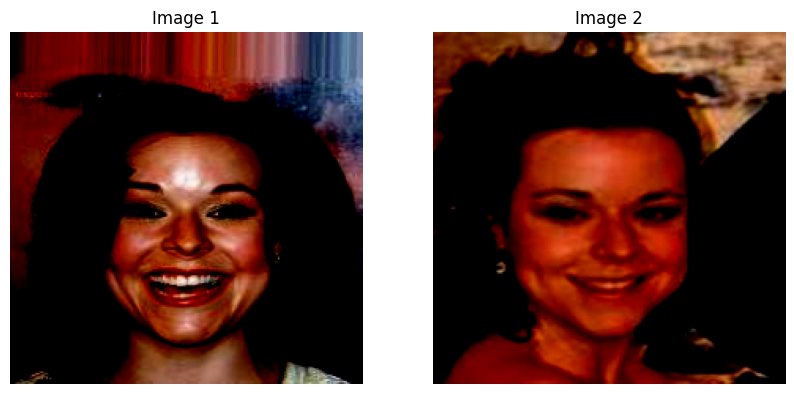

In [7]:
# Get one sample from the dataloader
dataiter = iter(test_loader)
img1, img2, label = next(dataiter)

# If you want to visualize the images, you can use matplotlib
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# For each image, we need to move the channels to the end and convert to numpy
# Assuming the images are in format (batch_size, channels, height, width)
img1_display = img1[0].permute(1, 2, 0).cpu().numpy()
img2_display = img2[0].permute(1, 2, 0).cpu().numpy()
print("\nLabel:", label[0])
# Display images
ax1.imshow(img1_display)
ax1.set_title('Image 1')
ax1.axis('off')

ax2.imshow(img2_display)
ax2.set_title('Image 2')
ax2.axis('off')

plt.show()

# Create the model

In [8]:
model = SiameseResNet()

# Find best Hyperparameters

In [9]:
train_loader_study = (create_subset_loader(train_loader,10000))
val_loader_study = (create_subset_loader(train_loader,2000))
run_optuna_study(train_loader_study, val_loader_study, n_trials=10, study_name="siamese_constrastive_HP_study")

[I 2025-05-25 15:22:53,657] Using an existing study with name 'siamese_constrastive_HP_study' instead of creating a new one.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/5:   7%|▋         | 22/313 [03:58<52:29, 10.82s/it, loss=1.83]  


[W 2025-05-25 15:26:53,114] Trial 8 failed with parameters: {'learning_rate': 3.1489116479568635e-05, 'weight_decay': 0.05669849511478854, 'margin': 7.453942447208348, 'patience': 6} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/arman/.conda/envs/RAML/lib/python3.13/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/home/arman/PycharmProjects/RAML1/src/ml/hyperparam_study.py", line 51, in <lambda>
    lambda trial: objective(trial, train_loader, val_loader),
                  ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arman/PycharmProjects/RAML1/src/ml/hyperparam_study.py", line 23, in objective
    results = model.train_model_constructive(
        train_loader=train_loader,
    ...<7 lines>...
        tuning_mode=True
    )
  File "/home/arman/PycharmProjects/RAML1/src/ml/resNet50.py", line 206, in train_model_constructive
    loss.backward()
    ~~~~~~~~~~~~

KeyboardInterrupt: 

# Train Model

In [10]:
optimizer = torch.optim.Adam(model.parameters(),
                                     lr=0.00001,
                                     weight_decay=1e-5)

In [ ]:
results = model.train_model_constructive(
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=ContrastiveLoss(margin=7.0),
        optimizer=optimizer,  # Pass the created optimizer
        num_epochs=5,
        device=DEVICE,
        patience=5,
        experiment_name='SiameseResNet',
        tuning_mode=True
    )

Epoch 1/5:   0%|          | 3/5087 [00:24<11:45:42,  8.33s/it, loss=0.0126] 

# Plot the results

In [ ]:
! mlflow ui --port 5000